# Image Super Resolution  
<br>
<br>
* 저해상도에서 고해상도로 이미지 화질을 증강시키는 작업.<br>
* 다운 샘플, 노이즈, 알 수 없는 블러(blur) 처리에 의해 품질이 저하된 '일련의 저해상도 이미지' 로부터 '고해상도 이미지' 를 추출
<br>

ex.) cctv 의 저해상도 얼굴을 인식하거나 판별.

In [14]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [15]:
base_directory = 'Image Super Resolution - Unsplash'
hires_folder = os.path.join(base_directory, 'high res')
lowres_folder = os.path.join(base_directory, 'low res')

In [16]:
data = pd.read_csv('Image Super Resolution - Unsplash/image_data.csv')
data['low_res'] = data['low_res'].apply(lambda x: os.path.join(lowres_folder, x))
data['high_res'] = data['high_res'].apply(lambda x: os.path.join(hires_folder, x))
data.head()

,low_res,high_res
0,Image Super Resolution - Unsplash/low res/1_2.jpg,Image Super Resolution - Unsplash/high res/1.jpg
1,Image Super Resolution - Unsplash/low res/2_2.jpg,Image Super Resolution - Unsplash/high res/2.jpg
2,Image Super Resolution - Unsplash/low res/3_2.jpg,Image Super Resolution - Unsplash/high res/3.jpg
3,Image Super Resolution - Unsplash/low res/4_2.jpg,Image Super Resolution - Unsplash/high res/4.jpg
4,Image Super Resolution - Unsplash/low res/5_2.jpg,Image Super Resolution - Unsplash/high res/5.jpg


In [17]:
batch_size = 4

image_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.15)
mask_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.15)

train_hiresimage_generator = image_datagen.flow_from_dataframe(
data, x_col = 'high_res', target_size = (800, 1200), class_mode = None, batch_size = batch_size,\
seed = 42, subset = 'training')

train_lowresimage_generator = image_datagen.flow_from_dataframe(
data, x_col = 'low_res', target_size = (800, 1200), class_mode = None, batch_size = batch_size,\
seed = 42, subset = 'training')

val_hiresimage_generator = image_datagen.flow_from_dataframe(
data, x_col = 'high_res', target_size = (800, 1200), class_mode = None, batch_size = batch_size,\
seed = 42, subset = 'validation')

val_lowresimage_generator = image_datagen.flow_from_dataframe(
data, x_col = 'low_res', target_size = (800, 1200), class_mode = None, batch_size = batch_size,\
seed = 42, subset = 'validation')

train_generator = zip(train_lowresimage_generator, train_hiresimage_generator)
val_generator = zip(val_lowresimage_generator, val_hiresimage_generator)

def imageGenerator(train_generator):
    for (low_res, hi_res) in train_generator:
        yield (low_res, hi_res)

Found 3198 validated image filenames.
Found 3198 validated image filenames.
Found 564 validated image filenames.
Found 564 validated image filenames.


<br>

# Data Visualization
<br>
<br>
* 저해상도 이미지 및 예측하고자 하는 해당 고해상도 출력.<br>
<br>

<br>

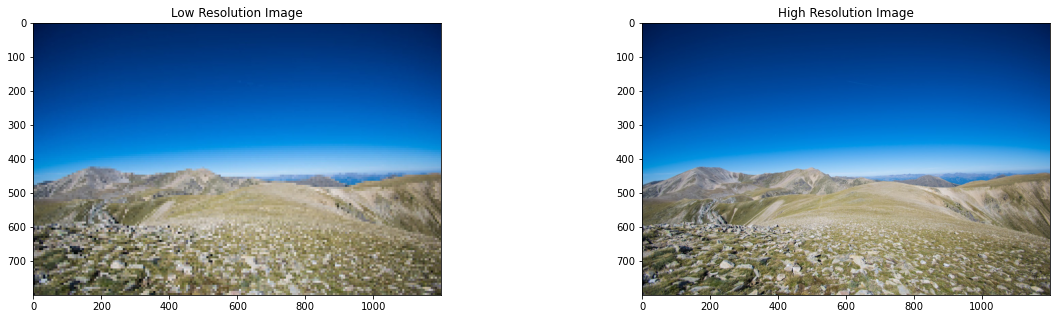

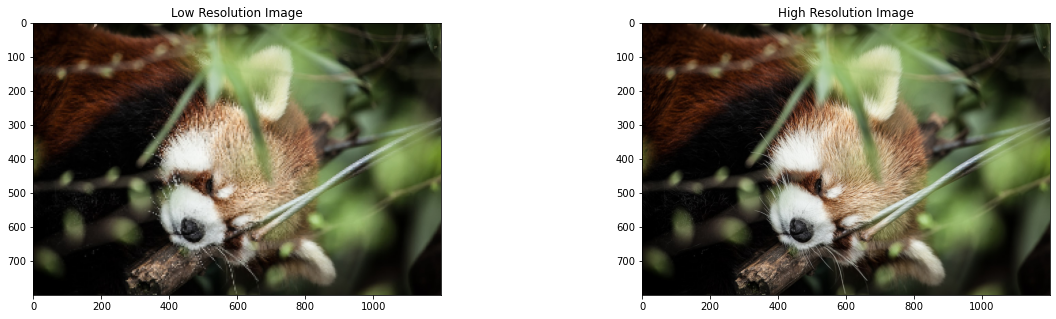

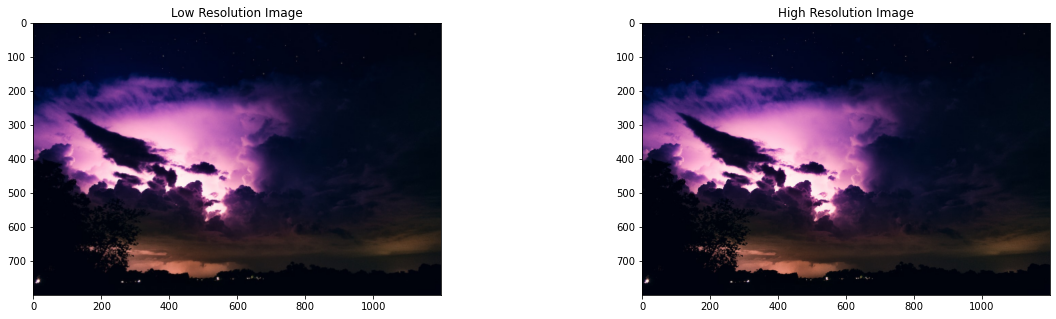

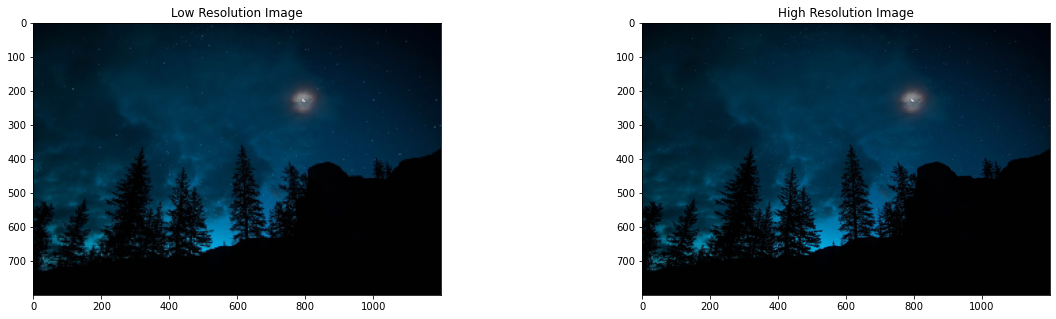

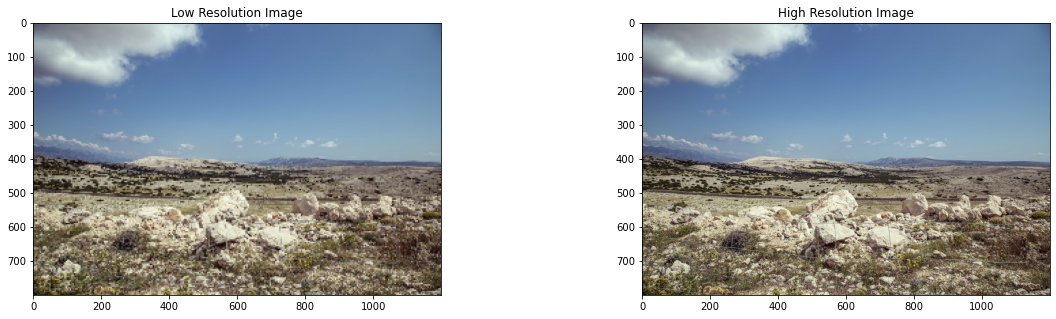

In [18]:
n = 0
for i, m in train_generator:
    img, out = i, m
    
    if n < 5:
        fig, axs = plt.subplots(1, 2, figsize = (20, 5))
        axs[0].imshow(img[0])
        axs[0].set_title('Low Resolution Image')
        axs[1].imshow(out[0])
        axs[1].set_title('High Resolution Image')
        plt.show()
        n += 1
        
    else:
        break

<br>

# 오토인코더 
<br>
<br>  

* 표현 학습(representaion learning) 작업에 신경망(neural network) 을 활용하는 비지도 학습 기술.  

* 오토인코더를 활용해 저해상도 이미지를 해당 고해상도 이미지로 재구성했습니다.  


<br>

In [19]:
input_img = Input(shape = (800, 1200, 3))

l1 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(input_img)
l2 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(l1)
l3 = MaxPooling2D(padding = 'same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(l3)
l5 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(l4)
l6 = MaxPooling2D(padding = 'same')(l5)
l7 = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(l6)

l8 = UpSampling2D()(l7)

l9 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(l8)
l10 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(l9)

l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(l12)
l14 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(l13)

l15 = add([l14, l2])

decoded = Conv2D(3, (3, 3), padding = 'same', activation = 'relu')(l15)

ae = Model(input_img, decoded)
ae.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [20]:
ae.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 800, 1200,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 800, 1200, 6  1792        ['input_2[0][0]']                
                                4)                                                                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 800, 1200, 6  36928       ['conv2d_10[0][0]']              
                                4)                                                          

In [21]:
train_samples = train_hiresimage_generator.samples
val_samples = val_hiresimage_generator.samples

train_img_gen = imageGenerator(train_generator)
val_img_gen = imageGenerator(val_generator)

In [22]:
model_path = 'autoencoder.h5'
checkpoint = ModelCheckpoint(model_path, monitor = 'val_loss', mode = 'min',\
                            save_best_only = True, verbose = 1)

earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 9, verbose = 1,\
                         restore_best_weights = True)

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 5,\
                                           verbose = 1, factor = 0.2, min_lr = 0.00000001)

In [ ]:
hist = ae.fit(train_img_gen,\
             steps_per_epoch = train_samples // batch_size,\
             validation_data = val_img_gen,\
             validation_steps = val_samples // batch_size,\
             epochs = 10, callbacks = [earlystop, checkpoint, learning_rate_reduction])

Epoch 1/10


* 코드 진행 결과, 작업 컴퓨터의 성능 문제로 설계한 모델에 1 epoch 도 학습되지 않는 문제가 발생했습니다.  
  
  
* learning curve 그래프(학습 데이터와 validation 데이터) 및 모델의 결과값(원본 이미지, 실측 자료 이미지, 예측된 초해상도 이미지) 은 참고 자료를 통해 확인했습니다.
  
  

* 참고 자료를 통해, 모델 학습 도중 재구성 손실값(reconstruction loss) 은 초기 반복 후에 안정 상태에 도달된 것으로 확인됐습니다.
  
  

* 해당 작업을 통해, 오토인코더를 활용해 고해상도 이미지 생성을 더욱 개선하는 데 사용될 수 있다는 것을 확인했습니다.

In [ ]:
# learning curves

plt.figure(figsize=(20,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# prediction

n = 0
for i,m in val_generator:
    img,mask = i,m
    sr1 = ae.predict(img)
    if n < 20:
        fig, axs = plt.subplots(1 , 3, figsize=(20,4))
        axs[0].imshow(img[0])
        axs[0].set_title('Low Resolution Image')
        axs[1].imshow(mask[0])
        axs[1].set_title('High Resolution Image')
        axs[2].imshow(sr1[0])
        axs[2].set_title('Predicted High Resolution Image')
        plt.show()
        n += 1
        
    else:
        break